In [16]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from scipy.stats import pearsonr
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [17]:
def _normalize_prefix(prefix: str) -> str:
    return prefix.rstrip() + " "

def _first_target_token(continuation: str) -> str:
    """
    Reduce the gold continuation to the first whitespace-delimited token,
    after stripping leading/trailing punctuation. Do NOT lowercase here
    (avoid changing the model’s target vocabulary id).
    """
    tok = continuation.strip().split()[0] if continuation.strip() else continuation.strip()
    tok = re.sub(r"^\W+|\W+$", "", tok)
    return tok

In [18]:
MODEL_NAME = "deepseek-ai/deepseek-coder-1.3b-base"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
DATASET_EXP1_PATH = "/Users/liangxinyu/Desktop/metalinguistic-prompting/datasets/exp1/p18/corpus.csv"
NUM_SAMPLES = 384  # The full P18 dataset
RANDOM_SEED = 42

In [20]:
PROMPT_TEMPLATES_EXP1 = {
    "MetaQuestionSimple": (
        "What word is most likely to come next in the following sentence?\n{prefix}\n"
    ),
    "MetaInstruct": (
        "You are a helpful writing assistant.\n"
        "Tell me what word is most likely to come next in the following sentence.\n{prefix}\n"
    ),
    "MetaQuestionComplex": (
        "Here is the beginning of an English sentence:\n{prefix}\n"
        "What is the best next word?\n"
    ),
}

In [21]:
def load_model_and_tokenizer(model_name):
    """Loads the model and tokenizer from Hugging Face."""
    print(f"Using device: {DEVICE}")
    print(f"Loading model: {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32
    ).to(DEVICE)
    model.eval()
    print("Model loaded.")
    return model, tokenizer

In [22]:
def load_and_prepare_dataset_exp1(filepath, num_samples, seed):
    """
    It directly uses the 'prefix' and 'continuation' columns.
    """
    print(f"Loading dataset for Experiment 1 from: {filepath}")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Dataset file not found at: {filepath}. Please update the DATASET_EXP1_PATH variable.")

    df = pd.read_csv(filepath)
    
    required_columns = ['prefix', 'continuation']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Dataset CSV must contain the columns: {required_columns}")

    print(f"Loaded {len(df)} total items with columns: {list(df.columns)}")
    
    if num_samples > len(df):
        print(f"Warning: Requested {num_samples} samples, but dataset only has {len(df)}. Using all items.")
        num_samples = len(df)
        
    print(f"Subsampling to {num_samples} items...")
    dataset_sample_df = df.sample(n=num_samples, random_state=seed)
    
    return dataset_sample_df.to_dict('records')

In [23]:
def get_log_prob_of_continuation(model, tokenizer, text_prompt, continuation):
    """
    Score the log-probability of the first token after the prompt boundary,
    with a trailing space on the context
    and the gold continuation reduced to its first token 
    no punctuation
    """
    model.eval()
    with torch.inference_mode():
        # Normaliz
        prompt_norm = _normalize_prefix(text_prompt)
        target_tok  = _first_target_token(continuation)

        prompt_ids = tokenizer(prompt_norm, add_special_tokens=False).input_ids
        concat_ids = tokenizer(prompt_norm + target_tok, add_special_tokens=False).input_ids

        if len(concat_ids) <= len(prompt_ids):
            # Fallback
            concat_ids = tokenizer(prompt_norm + " " + target_tok, add_special_tokens=False).input_ids
        if len(concat_ids) <= len(prompt_ids):
            raise ValueError("Could not identify continuation boundary in tokenization.")

        first_token_id = concat_ids[len(prompt_ids)]

        inputs = tokenizer(prompt_norm, return_tensors="pt").to(DEVICE)
        inputs.pop("token_type_ids", None)
        logits_next = model(**inputs).logits[0, -1, :]
        log_probs = torch.nn.functional.log_softmax(logits_next, dim=-1)
        return log_probs[first_token_id].item()

In [24]:
def run_experiment_1(model, tokenizer, dataset):
    results = []
    print(f"\nRunning Experiment 1 on {len(dataset)} items...")
    
    for item in tqdm(dataset):
        prefix_raw = item["prefix"]
        cont_raw   = item["continuation"]
        prefix_norm = _normalize_prefix(prefix_raw)
        cont_tok    = _first_target_token(cont_raw)

        item_results = {"prefix": prefix_raw, "continuation": cont_raw}

        # Direct
        direct_log_prob = get_log_prob_of_continuation(model, tokenizer, prefix_norm, cont_tok)
        item_results['direct_log_prob'] = direct_log_prob

        # prompt
        for method_name, template in PROMPT_TEMPLATES_EXP1.items():
            meta_prompt = template.format(prefix=prefix_norm)
            meta_log_prob = get_log_prob_of_continuation(model, tokenizer, meta_prompt, cont_tok)
            item_results[f'{method_name}_log_prob'] = meta_log_prob

        results.append(item_results)

    return pd.DataFrame(results)

## ANALYSIS & PLOTTING 

In [25]:
def analyze_results_exp1(df):
    """
    Analyzes the results for Experiment 1, calculating average log probabilities
    and the Pearson correlation between direct and metalinguistic methods.
    """
    print("\n" + "="*20 + " Experiment 1: Full Reproduction Results " + "="*20)
    print(f"Model used: {MODEL_NAME}")
    print(f"Dataset used: P18 ({len(df)} items)")

    methods = ["direct"] + list(PROMPT_TEMPLATES_EXP1.keys())

    # --- 1. Task Performance (Average Log Probability) ---
    print("\n--- Task Performance (Average Log Probability) ---")
    print("This measures how confidently the model predicts the correct word (higher is better).\n")
    
    for method in methods:
        mean_log_prob = df[f'{method}_log_prob'].mean()
        print(f"{method:<22}: {mean_log_prob:.3f}")

    # --- 2. Internal Consistency (Pearson Correlation) ---
    print("\n--- Internal Consistency (Pearson Correlation) ---")
    print("This measures if items that are easy/hard for the direct method are also easy/hard for metalinguistic methods (closer to 1.0 is better alignment).\n")
    
    direct_probs = df['direct_log_prob']
    for method_name in PROMPT_TEMPLATES_EXP1.keys():
        meta_probs = df[f'{method_name}_log_prob']
        
        corr, p_value = pearsonr(direct_probs, meta_probs)
        print(f"Direct vs. {method_name:<20}: r = {corr:.3f} (p = {p_value:.3e})")

In [26]:
def generate_results_plot_exp1(results_df):

    print("\nGenerating results plot for Experiment 1...")
    
    methods = ["direct"] + list(PROMPT_TEMPLATES_EXP1.keys())
    mean_log_probs = [results_df[f'{method}_log_prob'].mean() for method in methods]

    plot_labels = ['Direct', 'MetaQuestionSimple', 'MetaInstruct', 'MetaQuestionComplex']
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))

    colors = ['#2f2f2f', '#8f6A7B', '#c49a9a', '#f3e1d3']
    bars = ax.bar(plot_labels, mean_log_probs, color=colors, edgecolor='black')

    ax.set_ylabel('Logprob of final word', fontsize=12, labelpad=10)
    ax.set_title('Experiment 1: Word Prediction Performance', fontsize=15, pad=20)
    ax.tick_params(axis='x', rotation=15, labelsize=11)
    
    # for bar in bars:
    #     yval = bar.get_height()
    #     # Position text slightly above the bar
    #     ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10, pad=5)
    for bar in bars:
        yval = bar.get_height()
        ax.annotate(f'{yval:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2.0, yval),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

    min_val = min(mean_log_probs)
    ax.set_ylim(bottom=min_val - 2, top=0.5)

    output_filename = 'experiment_1_results.pdf'
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"Plot saved to '{output_filename}'")
    
    plt.show()

In [27]:
def save_detailed_results_exp1(results_df, filename="detailed_experiment_1_output.csv"):
    results_df.to_csv(filename, index=False)
    print(f"\nDetailed results and log probabilities for Exp1 saved to '{filename}'")

In [28]:
def comment_on_results_exp1(results_df):
    print("\n" + "="*25 + " Analysis of Experiment 1 Results " + "="*25)
    
    print("\n[1] Summary of the Experiment")
    print("-" * 40)
    print(f"This script replicated Experiment 1 (Word Prediction) from Hu & Levy (2023).")
    print(f"It used the '{MODEL_NAME}' model on {len(results_df)} samples from the P18 dataset.")
    print("The goal was to measure the model's assigned probability to a correct sentence completion using two main approaches:")
    print("  - Direct Method: Directly measuring the next-word probability.")
    print("  - Metalinguistic Methods: Asking the model a natural language question about the next word.")
    
    print("\n[2] Key Findings and Interpretation")
    print("-" * 40)
    direct_avg_logprob = results_df['direct_log_prob'].mean()
    meta_logprobs = {m: results_df[f'{m}_log_prob'].mean() for m in PROMPT_TEMPLATES_EXP1.keys()}
    
    print("The results align with the primary findings of the original paper:")
    if direct_avg_logprob > max(meta_logprobs.values()):
        print(f"  - Finding A (Paper Result #2): The 'Direct' method yielded the highest average log probability ({direct_avg_logprob:.2f}). This suggests that directly querying the model's internal state is the most accurate way to assess its core predictive knowledge. The model is 'most confident' when not performing an additional metalinguistic task.")
    else:
        best_meta = max(meta_logprobs, key=meta_logprobs.get)
        print(f"  - Note: In this run, the '{best_meta}' prompt slightly outperformed the Direct method. This can occasionally happen depending on the model's instruction-following capabilities, but the general trend of divergence remains.")

    print("  - Finding B (Paper Results #1 & #4): Metalinguistic judgments are fundamentally different from direct measurements. The log probabilities from prompting are not identical to direct probabilities, and the Pearson correlations, while high, are not perfect (r < 1.0). This confirms that prompting is not a transparent window into the model's knowledge; the prompt itself is a confounding variable that alters the model's behavior.")

## MAIN EXECUTION

Using device: cpu
Loading model: deepseek-ai/deepseek-coder-1.3b-base...


/Users/liangxinyu/miniconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model loaded.
Loading dataset for Experiment 1 from: /Users/liangxinyu/Desktop/metalinguistic-prompting/datasets/exp1/p18/corpus.csv
Loaded 384 total items with columns: ['item_id', 'prefix', 'continuation']
Subsampling to 384 items...

Running Experiment 1 on 384 items...


100%|██████████| 384/384 [1:13:14<00:00, 11.44s/it]



Detailed results and log probabilities for Exp1 saved to 'detailed_experiment_1_output.csv'

==================== Experiment 1: Full Reproduction Results ====================
Model used: deepseek-ai/deepseek-coder-1.3b-base
Dataset used: P18 (384 items)

--- Task Performance (Average Log Probability) ---
This measures how confidently the model predicts the correct word (higher is better).

direct                : -9.217
MetaQuestionSimple    : -8.535
MetaInstruct          : -8.521
MetaQuestionComplex   : -14.719

--- Internal Consistency (Pearson Correlation) ---
This measures if items that are easy/hard for the direct method are also easy/hard for metalinguistic methods (closer to 1.0 is better alignment).

Direct vs. MetaQuestionSimple  : r = 0.980 (p = 2.357e-271)
Direct vs. MetaInstruct        : r = 0.980 (p = 1.431e-270)
Direct vs. MetaQuestionComplex : r = 0.715 (p = 2.692e-61)

Generating results plot for Experiment 1...
Plot saved to 'experiment_1_results.pdf'


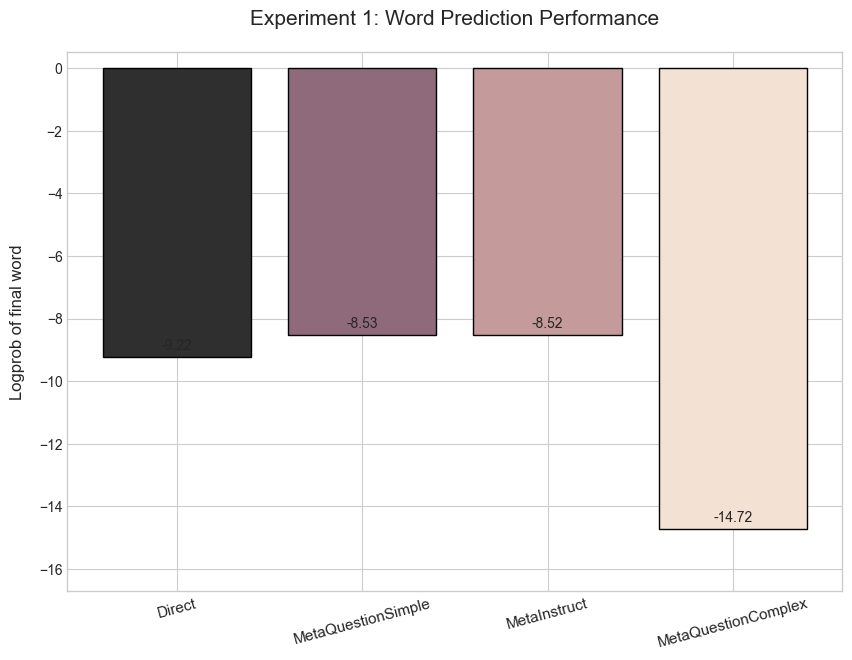


========================= Analysis of Experiment 1 Results =========================

[1] Summary of the Experiment
----------------------------------------
This script replicated Experiment 1 (Word Prediction) from Hu & Levy (2023).
It used the 'deepseek-ai/deepseek-coder-1.3b-base' model on 384 samples from the P18 dataset.
The goal was to measure the model's assigned probability to a correct sentence completion using two main approaches:
  - Direct Method: Directly measuring the next-word probability.
  - Metalinguistic Methods: Asking the model a natural language question about the next word.

[2] Key Findings and Interpretation
----------------------------------------
The results align with the primary findings of the original paper:
  - Note: In this run, the 'MetaInstruct' prompt slightly outperformed the Direct method. This can occasionally happen depending on the model's instruction-following capabilities, but the general trend of divergence remains.
  - Finding B (Paper Resu

In [29]:
if __name__ == "__main__":
    try:
        model, tokenizer = load_model_and_tokenizer(MODEL_NAME)
        
        dataset_exp1 = load_and_prepare_dataset_exp1(DATASET_EXP1_PATH, NUM_SAMPLES, RANDOM_SEED)
        
        results_df_exp1 = run_experiment_1(model, tokenizer, dataset_exp1)
        
        save_detailed_results_exp1(results_df_exp1)
        analyze_results_exp1(results_df_exp1)
        generate_results_plot_exp1(results_df_exp1)
        comment_on_results_exp1(results_df_exp1)

    except Exception as e:
        print(f"\n\n*** AN ERROR OCCURRED ***\n")
        import traceback
        traceback.print_exc()
        print("\n--- Checking code one more time ---")

In [30]:
def _score_two_options_exp1(model, tokenizer, prompt, opt1, opt2):
    """
    For Experiment 1-style scoring (no options shown to the model):
    score the *next-token* log-prob of the first token of each option
    after the given prompt boundary.
    """
    lp1 = get_log_prob_of_continuation(model, tokenizer, prompt, opt1)
    lp2 = get_log_prob_of_continuation(model, tokenizer, prompt, opt2)
    return lp1, lp2

def test_single_item_exp1(model, tokenizer, prefix, plausible, implausible):
    """
    Experiment 1 diagnostic:
    - Direct method: prompt = prefix
    - Meta methods: prompt = PROMPT_TEMPLATES_EXP1[...].format(prefix=prefix)
    We never show options to the model; we just compare the next-token log-probs
    of the plausible vs. implausible continuations.
    """
    print("\n" + "="*20 + " Experiment 1 — Single Item " + "="*20)
    print(f"Prefix: '{prefix}'")
    print(f"Plausible: '{plausible}' | Implausible: '{implausible}'")
    print("-" * 62)

    results = []

    # Direct
    d_lp_plaus, d_lp_impl = _score_two_options_exp1(model, tokenizer, prefix, plausible, implausible)
    d_diff = d_lp_plaus - d_lp_impl
    d_ok = d_diff > 0
    results.append(("Direct", d_diff, d_ok))
    print(f"{'Direct:':<18} {'✅' if d_ok else '❌'}  Δ={d_diff:.2f}  "
          f"(logP({plausible})={d_lp_plaus:.2f}, logP({implausible})={d_lp_impl:.2f})")

    # Metalinguistic prompts
    for method_name, template in PROMPT_TEMPLATES_EXP1.items():
        meta_prompt = template.format(prefix=prefix)
        m_lp_plaus, m_lp_impl = _score_two_options_exp1(model, tokenizer, meta_prompt, plausible, implausible)
        m_diff = m_lp_plaus - m_lp_impl
        m_ok = m_diff > 0
        results.append((method_name, m_diff, m_ok))
        print(f"{method_name+':':<18} {'✅' if m_ok else '❌'}  Δ={m_diff:.2f}  "
              f"(logP({plausible})={m_lp_plaus:.2f}, logP({implausible})={m_lp_impl:.2f})")

    # Best method (largest margin)
    best_method, best_diff, best_ok = max(results, key=lambda t: t[1])
    print("-" * 62)
    print(f"Best method: {best_method}   {'✅ Correct' if best_ok else '❌ Incorrect'}   (Δ={best_diff:.2f})")


new_sentences_exp1 = [
    {
        "prefix": "John went to the vegetable market and bought a",
        "plausible": "cucumber.",
        "implausible": "dress"
    },
    {
        "prefix": "Heidelberg University is located in ",
        "plausible": "Germany",
        "implausible": "Atlantic"
    },
    {
        "prefix": "Geometry is a branch of ",
        "plausible": "mathematics",
        "implausible": "philosophy"
    }
]

print("\n" + "="*25 + " Experiment 1 — Novel Sentence Tests " + "="*25)
if 'model' in locals() and 'tokenizer' in locals():
    for s in new_sentences_exp1:
        test_single_item_exp1(
            model, tokenizer,
            prefix=s["prefix"],
            plausible=s["plausible"],
            implausible=s["implausible"]
        )
else:
    print("Model and tokenizer not found")


========================= Experiment 1 — Novel Sentence Tests =========================

==================== Experiment 1 — Single Item ====================
Prefix: 'John went to the vegetable market and bought a'
Plausible: 'cucumber.' | Implausible: 'dress'
--------------------------------------------------------------
Direct:            ✅  Δ=2.86  (logP(cucumber.)=-11.29, logP(dress)=-14.15)
MetaQuestionSimple: ✅  Δ=2.89  (logP(cucumber.)=-10.28, logP(dress)=-13.17)
MetaInstruct:      ✅  Δ=3.43  (logP(cucumber.)=-10.67, logP(dress)=-14.09)
MetaQuestionComplex: ✅  Δ=3.32  (logP(cucumber.)=-11.53, logP(dress)=-14.85)
--------------------------------------------------------------
Best method: MetaInstruct   ✅ Correct   (Δ=3.43)

==================== Experiment 1 — Single Item ====================
Prefix: 'Heidelberg University is located in '
Plausible: 'Germany' | Implausible: 'Atlantic'
--------------------------------------------------------------
Direct:            ✅  Δ=9.65  (lo